In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

### Simple Slice sampler
- Density $\pi(x) \propto e^{-\sqrt{x}}$ 
- $\mathcal{X} = [0, 10]$ and $x_{min}=0$ and $ x_{max} = 10$
- $\pi$ is bounded and $\lambda(\mathcal{X}) < \infty$ 

In [5]:
def unnormalized_pi(x):
    return np.exp(-np.sqrt(x))

In [6]:
def slice_sampler(init_x, n_samples, domain):
    samples = []
    x = init_x
    for _ in tqdm(range(n_samples)):

        u = np.random.uniform(0, unnormalized_pi(x)) # generate the treshold
        x = np.random.uniform(domain[0] , min(domain[1], (-np.log(u))**2) ) # x ∼ U(A(u)) and π(x) > u  <=>  x < (-log(u))²
        samples.append(x)

    return np.array(samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 111464.08it/s]
C:\Users\keteb\AppData\Local\Temp\ipykernel_13952\2024645502.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  density /= np.trapz(density, x_vals)  # normalisation pour affichage


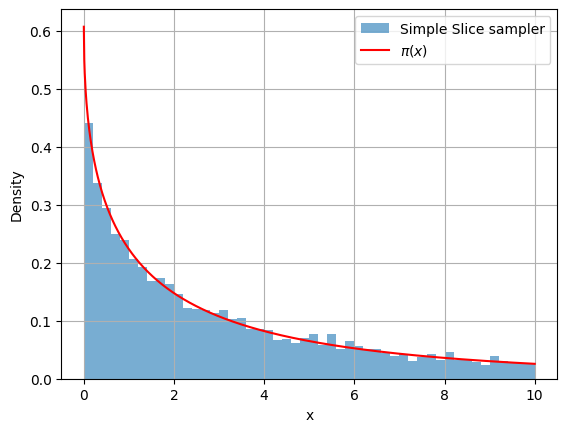

In [7]:
if __name__ == "__main__":
    domain=(0.0, 10.0)
    init_x= 1.0
    n_samples = 10000
    samples = slice_sampler(init_x, n_samples, domain)

    # Tracer histogramme + densité
    x_vals = np.linspace(0, 10, 1000)
    density = unnormalized_pi(x_vals)
    density /= np.trapz(density, x_vals)  # normalisation pour affichage

    plt.hist(samples, bins=50, density=True, alpha=0.6, label="Simple Slice sampler")
    plt.plot(x_vals, density, 'r-', label=r"$\pi(x)$")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.savefig("images/Slice_sampler_truncated.png", dpi=300, bbox_inches='tight')
    plt.show()

In [8]:
def slice_sampler(init_x, n_samples):
    samples = []
    x = init_x
    for _ in tqdm(range(n_samples)):

        u = np.random.uniform(0, unnormalized_pi(x)) # generate the treshold
        x = np.random.uniform(0 ,  (-np.log(u))**2) # x ∼ U(A(u)) and π(x) > u  <=>  x < (-log(u))²
        samples.append(x)

    return np.array(samples)

100%|██████████| 10000/10000 [00:00<00:00, 98691.83it/s]


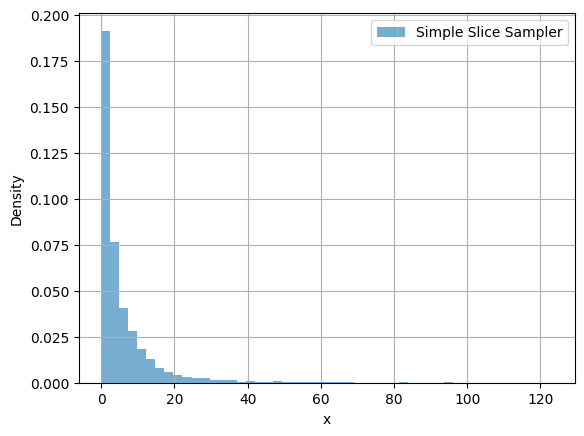

In [9]:
if __name__ == "__main__":
    init_x= 10.0
    n_samples = 10000
    samples = slice_sampler(init_x, n_samples)

    plt.hist(samples, bins=50, density=True, alpha=0.6, label="Simple Slice Sampler")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)

    plt.savefig("images/Slice_sampler.png", dpi=300, bbox_inches='tight')
    plt.show()

C:\Users\keteb\AppData\Local\Temp\ipykernel_13952\3499100002.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  density /= np.trapz(density, x_vals)  # Normalize for display


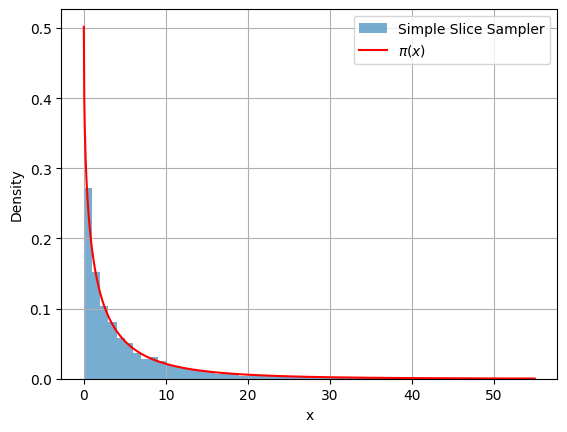

In [10]:
x_vals = np.linspace(0, 50 * 1.1, 1000)
density = unnormalized_pi(x_vals)
density /= np.trapz(density, x_vals)  # Normalize for display


plt.hist(list(filter(lambda x: x < 50, samples))
, bins=50, density=True, alpha=0.6, label="Simple Slice Sampler")
plt.plot(x_vals, density, 'r-', label=r"$\pi(x)$")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.savefig("images/Slice_sampler_fit.png", dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 10000/10000 [00:00<00:00, 113178.79it/s]


Effective Sample Size (ESS): 1746.87 / 10000


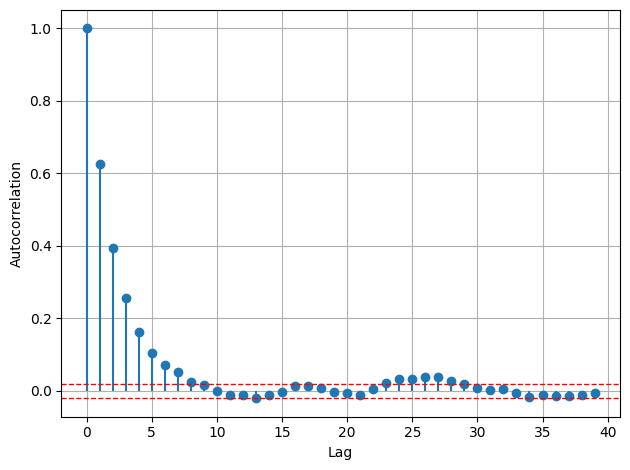

In [11]:
def compute_ess(sample, max_lag=100):
    n = len(sample)
    acf_vals = acf(sample, nlags=max_lag, fft=True)
    # Sum autocorrelations until they become negative
    positive_acf = acf_vals[1:]
    s = 1 + 2 * np.sum(positive_acf[positive_acf > 0])
    ess = n / s
    return ess, acf_vals

if __name__ == "__main__":
    init_x = 10
    n_samples = 10000
    samples = slice_sampler(init_x, n_samples)

    # Compute ESS
    ess, acf_vals = compute_ess(samples, max_lag=100)
    print(f"Effective Sample Size (ESS): {ess:.2f} / {n_samples}")
    conf_interval = 1.96 / np.sqrt(n_samples)
    # Plot ACF
    plt.stem(acf_vals[:40], basefmt=" ")
    plt.axhline(y=conf_interval, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=-conf_interval, color='red', linestyle='--', linewidth=1)
    #plt.title("Autocorrelation Function (ACF)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("images/acf_slice_sampler.png", dpi=300)
    plt.show()

### Random coupling of Slice Sampler 
- Density $\pi(x) \propto e^{-\sqrt{x}}$ 
- $\mathcal{X} = \mathbb{R}^+$ 

In [12]:
def slice_sampler_cpl(x_init, y_init, n_samples):
    samples = []
    x = x_init
    y = y_init
    for _ in range(n_samples):
        u_ =  np.random.uniform(0, 1)
        ux = u_ * unnormalized_pi(x)
        uy=  u_ * unnormalized_pi(y)
        # generate the treshold
        u =  np.random.uniform(0, 1)
        x = u *  (-np.log(ux))**2
        y = u *  (-np.log(uy))**2  # x ∼ U(A(u)) and π(x) > u  <=>  x < (-log(u))²
        samples.append((x, y))

    return np.array(samples)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\keteb\AppData\Local\Temp\ipykernel_13952\3029211301.py:13: RuntimeWarning: divide by zero encountered in log
  distances[i] = np.log(np.abs(x - y)) # distance between coupled chains
100%|██████████| 100/100 [00:01<00:00, 80.62it/s]
C:\Users\keteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\_core\_methods.py:190: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


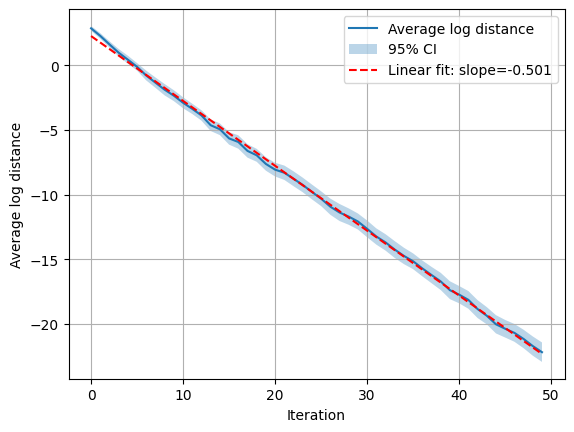

In [13]:
if __name__ == "__main__":
    init_x = 1.0
    init_y = 40.0
    n_samples = 1000
    N = 100  # number of repetitions to estimate the mean and confidence intervals

    distances = np.zeros((N, n_samples))  # to store distance at each iteration
    
    for i in tqdm(range(N)):
        sample = slice_sampler_cpl(init_x, init_y, n_samples)
        x = sample[:, 0]
        y = sample[:, 1]
        distances[i] = np.log(np.abs(x - y)) # distance between coupled chains

    # Mean and standard deviation over N repetitions
    mean_log_dist = distances.mean(axis=0)
    mean_distance =  mean_log_dist[~np.isneginf(mean_log_dist)]
    iterations = np.arange(len(mean_distance))

    slope, intercept, r_value, p_value, std_err = linregress(iterations, mean_distance)
    reg_line = slope * iterations + intercept
    std_distance = distances.std(axis=0)[:len(mean_distance)]

    # 95% confidence interval (normal approximation)
    ci = 1.96 * std_distance / np.sqrt(N)

    # Plotting the average distance and confidence band
    
    plt.plot(iterations, mean_distance, label='Average log distance')
    plt.fill_between(iterations, mean_distance - ci, mean_distance + ci, alpha=0.3, label='95% CI')
    #plt.xscale('log')
    plt.plot(iterations, reg_line, '--', color='red', label=f'Linear fit: slope={slope:.3f}')
    plt.xlabel("Iteration")
    plt.ylabel("Average log distance")
    plt.legend()
    plt.grid()
    plt.savefig("images/contraction_CRN.png", dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
np.exp(slope)

np.float64(0.6057371409054377)

C:\Users\keteb\AppData\Local\Temp\ipykernel_13952\4138793194.py:21: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.arange(n_samples), np.log(mean_dist), label=f'gap= {init_y-init_x:.0f}')


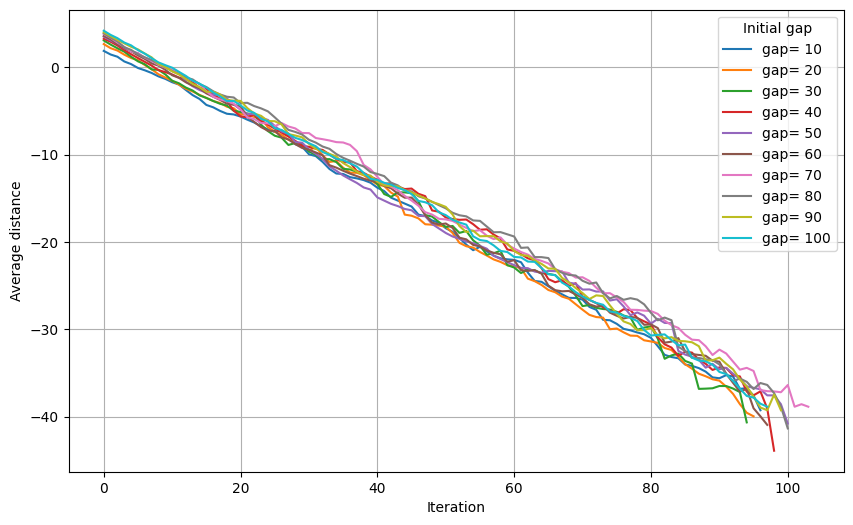

In [15]:
# Main
if __name__ == "__main__":
    init_x = 1.0
    n_samples = 1000
    N = 100  # number of repetitions per k

    plt.figure(figsize=(10, 6))

    for k in range(1, 11):
        init_y = init_x + k * 10
        distances = np.zeros((N, n_samples))  # store N trajectories

        for i in range(N):
            sample = slice_sampler_cpl(init_x, init_y, n_samples)
            x = sample[:, 0]
            y = sample[:, 1]
            distances[i] = np.abs(x - y)

        # Mean distance for current k
        mean_dist = distances.mean(axis=0)
        plt.plot(np.arange(n_samples), np.log(mean_dist), label=f'gap= {init_y-init_x:.0f}')

    # Plot settings
    plt.xlabel("Iteration")
    plt.ylabel("Average distance")
    plt.legend(title="Initial gap")
    plt.grid()

    # Save the figure
    plt.savefig("images/contraction_gap_CRN.png", dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
def coalescence_probability(samples, espilon):
    """
    Compute the coalescence probability at each iteration.

    Parameters:
    - samples: array of shape (N_runs, n_samples, 2)
    - espilon: threshold to consider chains as coalesced.

    Returns:
    - probs: array with the coalescence probability at each iteration.
    """
    N_runs, n_samples, _ = samples.shape
    probs = np.zeros(n_samples)
    for t in range(n_samples):
        distances = np.abs(samples[:, t, 0] - samples[:, t, 1])
        count_coalesced = np.sum(distances < espilon)
        probs[t] = count_coalesced / N_runs
    return probs

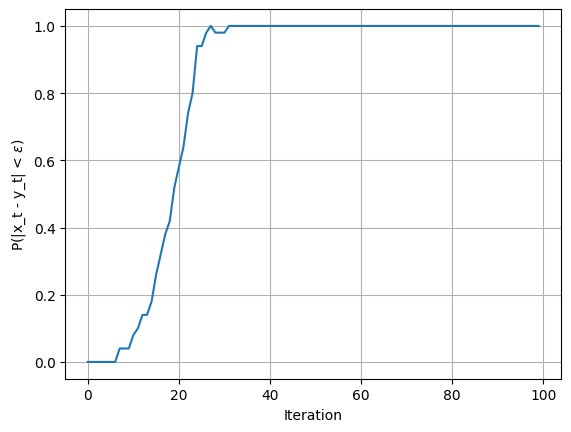

In [17]:
if __name__ == "__main__":

    # Parameters
    x_init = 1.0
    y_init = 40.0
    n_samples = 100
    N_runs = 50  # Number of repetitions for estimation
    epsilon = 1e-3

    # Run multiple coupled chains
    all_samples = np.zeros((N_runs, n_samples, 2))
    for i in range(N_runs):
        sample = slice_sampler_cpl(x_init, y_init, n_samples)
        all_samples[i] = sample

    # Compute coalescence probability
    probs = coalescence_probability(all_samples, epsilon)

    # Plot results
    plt.plot(probs)
    plt.xlabel("Iteration")
    plt.ylabel(r"P(|x_t - y_t| < $\varepsilon)$")
    plt.grid()
    plt.savefig("images/Prob_CRN.png", dpi=300, bbox_inches='tight')
    plt.show()

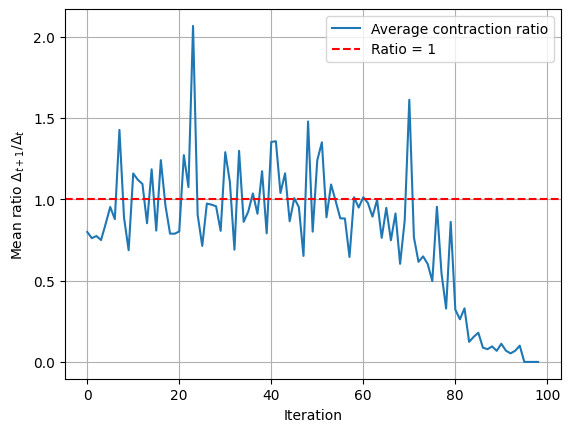

In [18]:


def contraction_ratio(samples):
    """
    Compute contraction ratio r_t = d_{t+1} / d_t for coupled chains.

    Parameters:
    - samples: array of shape (n_samples, 2) with (x_t, y_t) pairs.

    Returns:
    - ratios: array of length n_samples-1 with contraction ratios.
    """
    x = samples[:, 0]
    y = samples[:, 1]
    distances = np.abs(x - y)

    epsilon = 1e-12
    distances_safe = np.where(distances == 0, epsilon, distances)

    ratios = distances[1:] / distances_safe[:-1]

    return ratios

# Parameters
x_init = 1.0
y_init = 40.0
n_samples = 100
N_runs = 50  # number of repetitions

# Generate multiple runs
all_ratios = np.zeros((N_runs, n_samples-1))

for i in range(N_runs):
    sample = slice_sampler_cpl(x_init, y_init, n_samples)
    all_ratios[i] = contraction_ratio(sample)

# Compute mean ratio across runs
mean_ratios = np.mean(all_ratios, axis=0)

# Plot average contraction ratio
plt.plot(mean_ratios, label='Average contraction ratio')
plt.axhline(1, color='red', linestyle='--', label='Ratio = 1')
plt.xlabel("Iteration")
plt.ylabel(r"Mean ratio $\Delta_{t+1} / \Delta_t$")
plt.legend()
plt.grid()
plt.savefig("images/Ratio_CRN.png", dpi=300, bbox_inches='tight')
plt.show()


### Coupling of the simple Slice sampler with maximal coupling
1) CRN slice + maximal coupling on X

In [23]:
def indicator(x, m):
    return int(x <= m and x >= 0)/m

def max_cpl(m_, m):
    x = np.random.uniform(0, m_)
    w = np.random.uniform(0, 1)

    if w * indicator(x, m_) <= indicator(x, m):
        return x, x
    
    y = np.random.uniform(0, m)
    w = np.random.uniform(0, 1)
    while indicator(y, m_) > w * indicator(y, m):
        y = np.random.uniform(0, m)
        w = np.random.uniform(0, 1)
    return x, y


In [24]:
def SS_1(x_init, y_init, n_samples):
    samples = []
    x = x_init
    y = y_init
    for _ in range(n_samples):
        u_ =  np.random.uniform(0, 1)
        ux = u_ * unnormalized_pi(x)
        uy=  u_ * unnormalized_pi(y)
        # generate the treshold
        x, y = max_cpl((-np.log(ux))**2, (-np.log(uy))**2)
        # x ∼ U(A(u)) and π(x) > u  <=>  x < (-log(u))²
        samples.append((x, y))

    return np.array(samples)

100%|██████████| 100/100 [00:00<00:00, 745.54it/s]


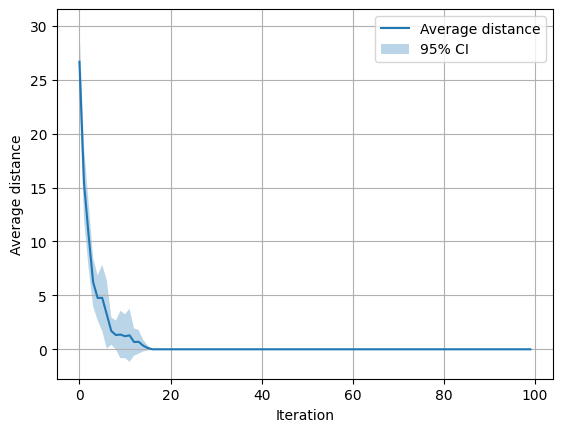

In [25]:
if __name__ == "__main__":
    init_x = 1.0
    init_y = 40.0
    n_samples = 100
    N = 100  # number of repetitions to estimate the mean and confidence intervals

    distances = np.zeros((N, n_samples))  # to store distance at each iteration

    for i in tqdm(range(N)):
        sample = SS_1(init_x, init_y, n_samples)
        x = sample[:, 0]
        y = sample[:, 1]
        distances[i] = np.abs(x - y)  # distance between coupled chains

    # Mean and standard deviation over N repetitions
    mean_distance = distances.mean(axis=0)
    std_distance = distances.std(axis=0)

    # 95% confidence interval (normal approximation)
    ci = 1.96 * std_distance / np.sqrt(N)

    # Plotting the average distance and confidence band
    iterations = np.arange(n_samples)
    plt.plot(iterations, mean_distance, label='Average distance')
    plt.fill_between(iterations, mean_distance - ci, mean_distance + ci, alpha=0.3, label='95% CI')
    plt.xlabel("Iteration")
    plt.ylabel("Average distance")
    plt.legend()
    plt.grid()

    plt.savefig("images/contraction_SS1.png", dpi=300, bbox_inches='tight')
    plt.show()

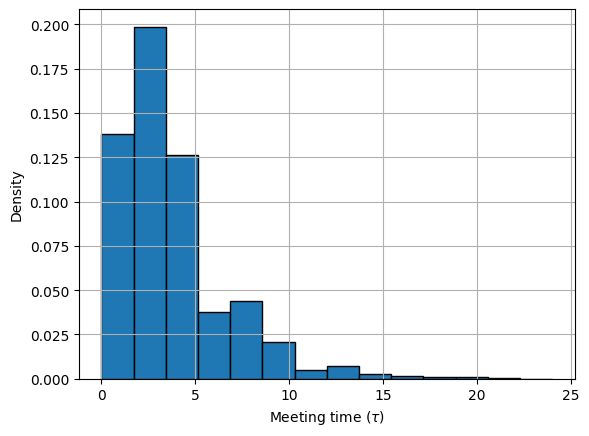

In [26]:
if __name__ == "__main__":
    init_x = 1.0
    init_y = 40.0
    n_samples = 100
    N = 10000
    tau = []
    bins = int(np.log2(N)) + 1
    for _ in range(N):
    
        sample = SS_1(init_x, init_y, n_samples)
        x = sample[:, 0]
        y = sample[:, 1]
        for i in range(len(x)):
            if x[i] == y[i]:
                tau.append(i)
                break
        
    plt.hist(tau, bins= bins, density=True, edgecolor='black')
    plt.xlabel(r"Meeting time ($\tau$)")    
    plt.ylabel("Density")
    plt.grid(True)
    plt.savefig("images/meet_time_SS1.png", dpi=300, bbox_inches='tight')
    plt.show()

    

2) maximal coupling for the two slices

In [27]:
def SS_2(x_init, y_init, n_samples):
    samples = []
    x = x_init
    y = y_init
    for _ in range(n_samples):
        
        ux, uy =  max_cpl(unnormalized_pi(x), unnormalized_pi(y))
        # generate the treshold
        x, y = max_cpl((-np.log(ux))**2, (-np.log(uy))**2)
        # x ∼ U(A(u)) and π(x) > u  <=>  x < (-log(u))²
        samples.append((x, y))

    return np.array(samples)

100%|██████████| 100/100 [00:00<00:00, 615.39it/s]


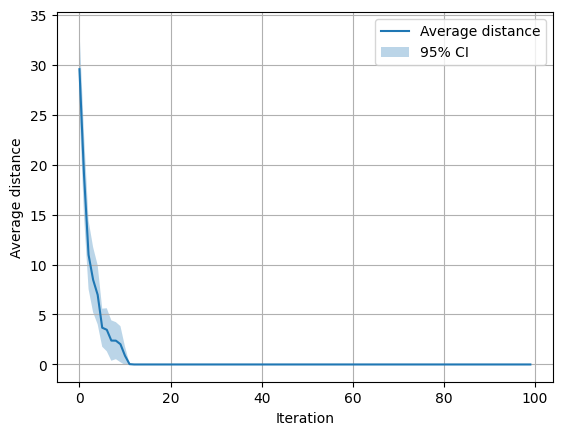

In [28]:
if __name__ == "__main__":
    init_x = 1.0
    init_y = 40.0
    n_samples = 100
    N = 100  # number of repetitions to estimate the mean and confidence intervals

    distances = np.zeros((N, n_samples))  # to store distance at each iteration

    for i in tqdm(range(N)):
        sample = SS_2(init_x, init_y, n_samples)
        x = sample[:, 0]
        y = sample[:, 1]
        distances[i] = np.abs(x - y)  # distance between coupled chains

    # Mean and standard deviation over N repetitions
    mean_distance = distances.mean(axis=0)
    std_distance = distances.std(axis=0)

    # 95% confidence interval (normal approximation)
    ci = 1.96 * std_distance / np.sqrt(N)

    # Plotting the average distance and confidence band
    iterations = np.arange(n_samples)
    plt.plot(iterations, mean_distance, label='Average distance')
    plt.fill_between(iterations, mean_distance - ci, mean_distance + ci, alpha=0.3, label='95% CI')
    plt.xlabel("Iteration")
    plt.ylabel("Average distance")
    plt.legend()
    plt.grid()

    plt.savefig("images/contraction_SS2.png", dpi=300, bbox_inches='tight')
    plt.show()

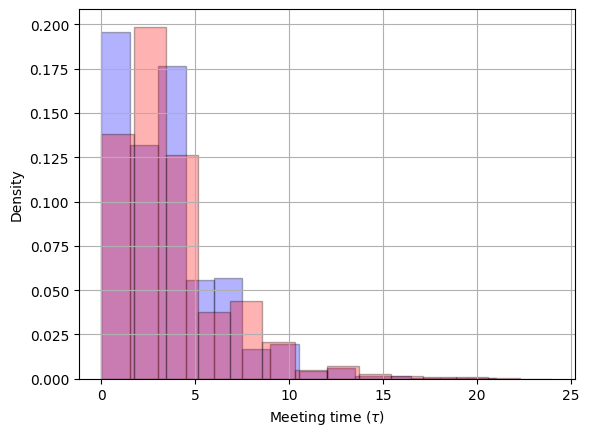

In [30]:
if __name__ == "__main__":
    init_x = 1.0
    init_y = 40.0
    n_samples = 100
    N = 10000
    tau_ = []
    bins = int(np.log2(N)) + 1
    for _ in range(N):
    
        sample = SS_2(init_x, init_y, n_samples)
        x = sample[:, 0]
        y = sample[:, 1]
        for i in range(len(x)):
            if x[i] == y[i]:
                tau_.append(i)
                break
        
    plt.hist(tau_, bins= bins, alpha=0.3, density=True, label='x', color='blue', edgecolor='black')
    plt.hist(tau, bins= bins, alpha=0.3, density=True, label='y', color='red', edgecolor='black')
    plt.xlabel(r"Meeting time ($\tau$)")    
    plt.ylabel("Density")
    plt.grid(True)
    plt.savefig("images/meet_time_SS2.png", dpi=300, bbox_inches='tight')
    plt.show()


In [281]:
def log_likelihood(x, m, v):
    """Unnormalized log Gaussian: -0.5 * (x - m)^T V^{-1} (x - m)"""
    diff = x - m
    
    return (-0.5/v) * diff**2

In [282]:
def coupled_transition2(x, y, m, v):
    w = np.random.normal(0, 1)  # w ~ N(0, I)

    log_px, log_py = log_likelihood(x, m, v), log_likelihood(y, m, v)
    u_slice = np.log(np.random.uniform(0, 1))
    log_tx = log_px + u_slice
    log_ty = log_py + u_slice

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal_x = x * np.cos(theta) + w * np.sin(theta)
    log_p_proposal_x = log_likelihood(proposal_x, m, v)

    theta_visited = [theta]
    while log_p_proposal_x < log_tx :
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        theta_visited.append(theta)
        proposal_x = x * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_x = log_likelihood(proposal_x, m, v)

    proposal_y = y * np.cos(theta_visited[0]) + w * np.sin(theta_visited[0])
    log_p_proposal_y = log_likelihood(proposal_y, m, v)

    counter = 1
    while log_p_proposal_y < log_ty :
        if counter < len(theta_visited):
            theta = theta_visited[counter]
            counter += 1
        else:
            theta = np.random.uniform(theta_min, theta_max)
        
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        proposal_y = y * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_y = log_likelihood(proposal_y, m, v) 

    return proposal_x, proposal_y, theta_visited[-1], theta


def coupled_ess2(x_init, y_init, m, v, N):
    samples = [(x_init, y_init)]
    x, y = samples[0]
    list_theta2 = []

    for _ in tqdm(range(N)):
        x, y, theta1, theta2 = coupled_transition2(x, y, m, v)
        list_theta2.append((theta1, theta2))
        samples.append((x, y))

    return samples, list_theta2

In [ ]:
if __name__ == "__main__":
    m, v = 1, 2

    x_init, y_init = 5, -3
    N = 10000

    coupled_chain, list_theta, list_w = coupled_ess(x_init, y_init, m, v, N)

### 1- Coupling from the Past (CFTP) of the slice sampler

In [ ]:

def single_step(x, e, W):
    """
    Implements f(x, (e, W)) = x' cf Section 4.
    """
    u = e * unnormalized_pi(x)
    for wj in W:
        if unnormalized_pi(wj) > u:
            return wj
    raise RuntimeError("Did not find an acceptable W_j")

def generate_W_sequence(W_sample_size):
    w0 = np.random.uniform(0,10)
    W = [w0]

    for _ in range(W_sample_size-1):
        w_new = np.random.uniform(0, W[-1])
        W.append(w_new)
    return W

In [45]:

def CFTP_SS(max_iterations, W_sample_size):
    """
    Implements CFTP with a stochastic recursive sequence (Section 4)
    """
    xmin = 0
    xmax = 10

    T = 1

    e_seq = [np.random.uniform(0, 1) for _ in range(max_iterations)]
    w_seq = [generate_W_sequence(W_sample_size) for _ in range(max_iterations)]
    while T <= max_iterations:
        

        x_lower = xmin
        x_upper = xmax

        for i in reversed(range(T)):
            x_lower = single_step(x_lower, e_seq[i], w_seq[i])
            x_upper = single_step(x_upper, e_seq[i], w_seq[i])

        if np.isclose(x_lower, x_upper, atol=1e-8):
            return x_lower # Perfect sample from pi(x)
        else:
            T *= 2

    raise RuntimeError("CFTP failed to coalesce within max_iterations")



<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
C:\Users\keteb\AppData\Local\Temp\ipykernel_14976\392307719.py:18: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Perfect Samples from $\pi(x)$ via Slice Sampler and CFTP")
100%|██████████| 1000/1000 [01:17<00:00, 12.90it/s]
C:\Users\keteb\AppData\Local\Temp\ipykernel_14976\392307719.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  density /= np.trapz(density, x_vals)  # display with normalization


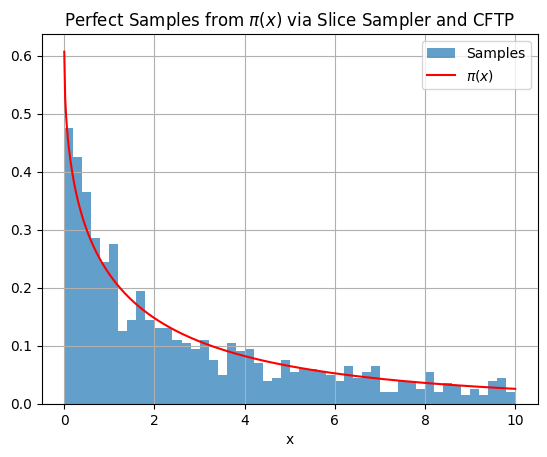

In [47]:
if __name__ == "__main__":
    max_iterations=2**5
    W_sample_size=1000
    samples = [CFTP_SS(max_iterations, W_sample_size) for _ in tqdm(range(1000))]
    
    
    import matplotlib.pyplot as plt
    plt.hist(samples, bins=50, density=True, alpha=0.7, label='Samples')
    
    x_vals = np.linspace(0, 10, 500)
    density = unnormalized_pi(x_vals)
    density /= np.trapz(density, x_vals)  # display with normalization

    plt.plot(x_vals, density, label=r'$\pi(x)$', color='red')

    plt.legend()
    plt.grid()
    plt.title("Perfect Samples from $\pi(x)$ via Slice Sampler and CFTP")
    plt.xlabel("x")
    plt.show()

### 2- CFTP with lower process 
- $\pi(x) = \frac{e^{-x}}{1+x}$ and $\pi^{lb}(x) = e^{-qx},\, q\in (0, 1)$ 